In [8]:
from datetime import date, timedelta
import import_ipynb
from Simulations import *
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy
from functools import reduce
import datetime
import pandas as pd
import numpy as np
from re import sub


def dollar_string_to_float(money):
    return float(sub(r'[^\d.]', '', money))


In [9]:
pool_info_df = pd.read_csv('emerging_markets_pool_info.csv')  # Load pool data
company_info_df = pd.read_csv('company_info.csv')  # Load the company info csv
pool_info_df['Borrower Companies'] = pool_info_df['Borrower Companies'].fillna("")
company_set = set()
for row in pool_info_df["Borrower Companies"]:
    split = row.split(",")
    for item in split:
        company_set.add(item.strip().lower())
company_info_df = company_info_df[company_info_df["Company Name"].str.strip().str.lower().isin(company_set)].reset_index()

### Company Correlation Matrix

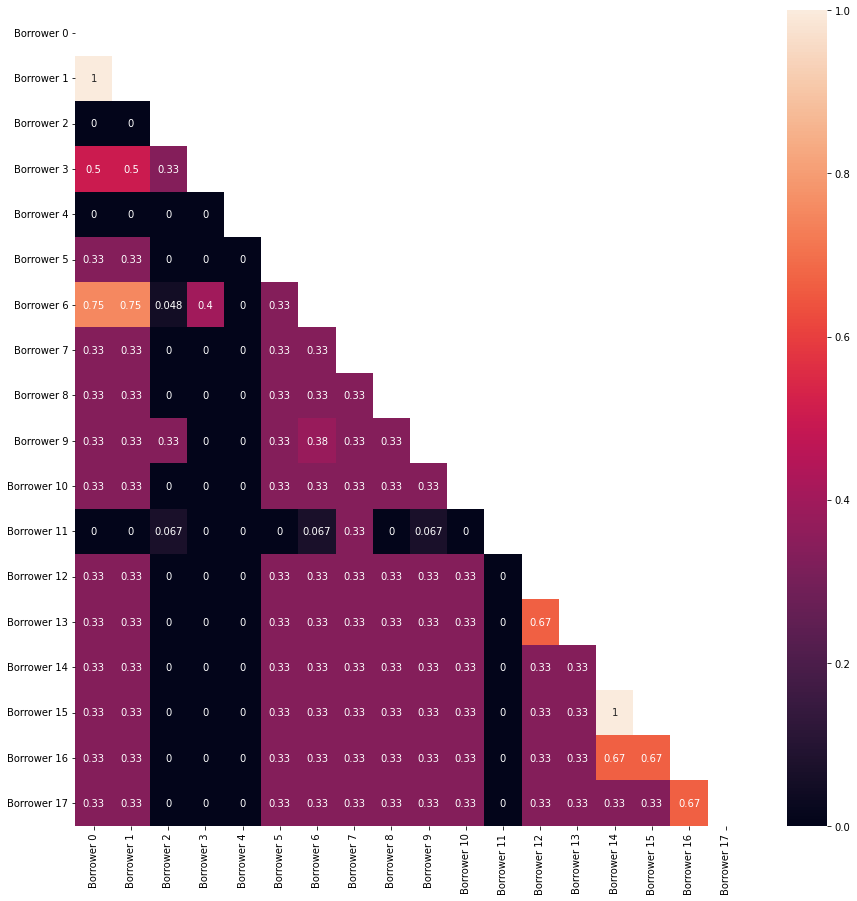

In [10]:
company_correlation_dict = get_company_correlation(
    company_info_df)  # Compute correlation dict


company_correlation_matrix = np.zeros(
    (len(company_info_df), len(company_info_df)))
company_names = company_info_df['Company Name']
for index1, company1 in company_names.items():
    for index2, company2 in company_names.items():
        company_correlation_matrix[index1][index2] = company_correlation_dict[company1.strip(
        ).lower()][company2.strip().lower()]

mask = np.triu(np.ones_like(company_correlation_matrix, dtype=bool))

fig, ax = plt.subplots(figsize=(15, 15))         # Sample figsize in inches

mask_company_names = True

if mask_company_names == True:
    sns.heatmap(company_correlation_matrix,  # Plot the matrix
            mask=mask,
            annot=True,
            xticklabels=["Borrower "+str(i) for i in range(len(company_info_df))],
            yticklabels=["Borrower "+str(i) for i in range(len(company_info_df))],   
            ax=ax)

    
else:
    sns.heatmap(company_correlation_matrix,  # Plot the matrix
            mask=mask,
            xticklabels=company_info_df['Company Name'],
            yticklabels=company_info_df['Company Name'],
            annot=True,
            ax=ax)

### Pool correlation matrix

<AxesSubplot:>

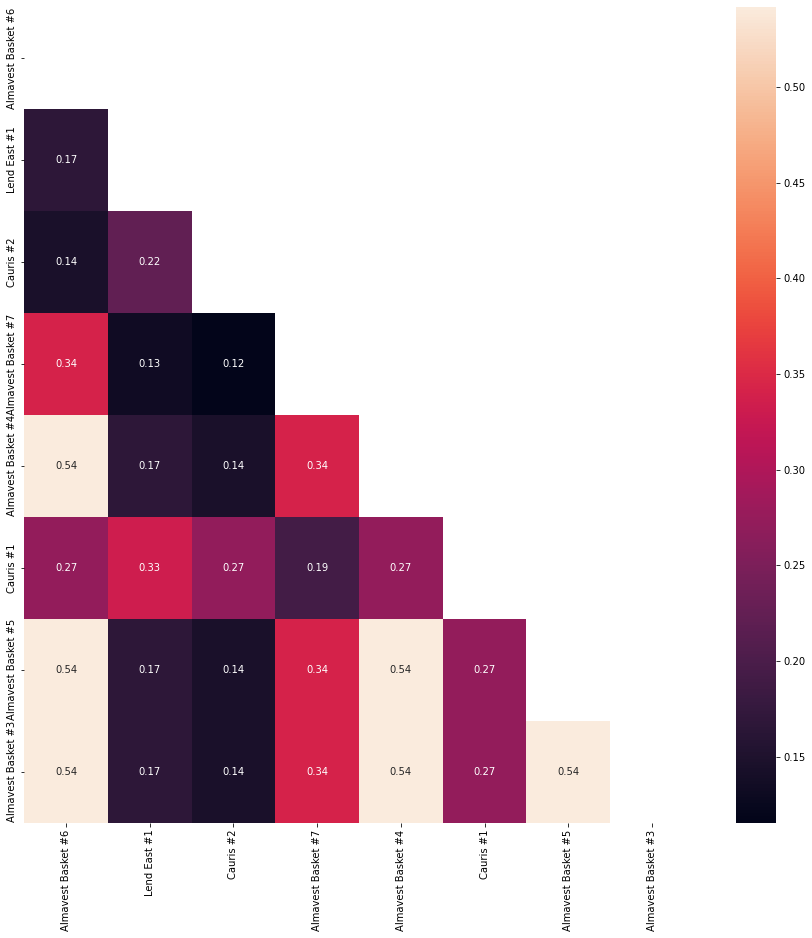

In [11]:
pool_correlation_matrix = get_pool_correlation(
    pool_info_df, company_correlation_dict)  # Compute correlation matrix
np.fill_diagonal(pool_correlation_matrix, 1)  # Diagonal values should be 1

# Create mask to remove duplications
mask = np.triu(np.ones_like(pool_correlation_matrix, dtype=bool))

fig, ax = plt.subplots(figsize=(15, 15))         # Sample figsize in inches

# plot the heatmap
sns.heatmap(pool_correlation_matrix,
            mask=mask,
            xticklabels=pool_info_df['Lending Pool Name'],
            yticklabels=pool_info_df['Lending Pool Name'],
            annot=True,
            ax=ax)


In [12]:
low_risk_pool_info_array = []
pool_info_array = []  # Initialize the pool info array
high_risk_pool_info_array = []
for i, row in pool_info_df.iterrows():  # Loop through the pool data
    low_risk_pool_info_array.append({"name": row["Lending Pool Name"], "principal": dollar_string_to_float(row["Outstanding Loans"]),
                            "maturity_date": datetime.datetime.strptime(row["Full Repayment Due"], "%d %b %Y").date(), "payment_period": float(row["Payment frequency"].split()[0]),
                            "rate": 0.05,"amortization":row["Amortization"]})
    
    
    pool_info_array.append({"name": row["Lending Pool Name"], "principal": dollar_string_to_float(row["Outstanding Loans"]),
                            "maturity_date": datetime.datetime.strptime(row["Full Repayment Due"], "%d %b %Y").date(), "payment_period": float(row["Payment frequency"].split()[0]),
                            "rate": float(row["Financing Cost"].split("%")[0])/100,"amortization":row["Amortization"]})
    
    high_risk_pool_info_array.append({"name": row["Lending Pool Name"], "principal": dollar_string_to_float(row["Outstanding Loans"]),
                            "maturity_date": datetime.datetime.strptime(row["Full Repayment Due"], "%d %b %Y").date(), "payment_period": float(row["Payment frequency"].split()[0]),
                            "rate": 0.2,"amortization":row["Amortization"]})
    
    
    # Append info for each pool

low_risk_pool_array = []
high_risk_pool_array = []
pool_array = []  # Initialize the pool array
for pool_info in pool_info_array:  # Loop over the info and create lending pool objects appendign them to list
    pool_array.append(LendingPool(pool_info))
for pool_info in low_risk_pool_info_array:  
    low_risk_pool_array.append(LendingPool(pool_info))
for pool_info in high_risk_pool_info_array: 
    high_risk_pool_array.append(LendingPool(pool_info))

### Regime 1 - Pools are assigned a 5% financing rate to model low riskiness

Initial investment total is  1000.0
10 percentile capital loss is 0.0
25 percentile capital loss is 0.0
50 percentile capital loss is 0.0
75 percentile capital loss is 0.0
99 percentile capital loss is 265.09923087335557
Mean capital loss is  31.298459220224895


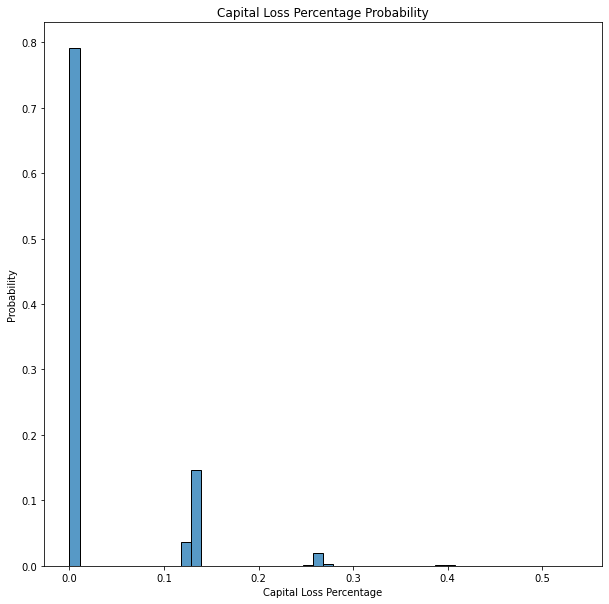

In [9]:
simulation_engine_low = SimulationEngine(low_risk_pool_array, pool_correlation_matrix)
simulation_engine_low.simulate_paths(
    pool_array[-1].maturity_date, 50000) 
analysisEngine = AnalysisEngine(
    simulation_engine_low)  # Initialize analysis engine
initial_investment = [1000/len(pool_array) for _ in range(len(pool_array))]
analysisEngine.visualize_capital_losses(initial_investment)

### Regime 2 - Pools are assigned their real world financing rates.

Initial investment total is  1000.0
10 percentile capital loss is 0.0
25 percentile capital loss is 0.0
50 percentile capital loss is 0.0
75 percentile capital loss is 141.75085616438335
99 percentile capital loss is 426.7846071449516
Mean capital loss is  80.68448611005823


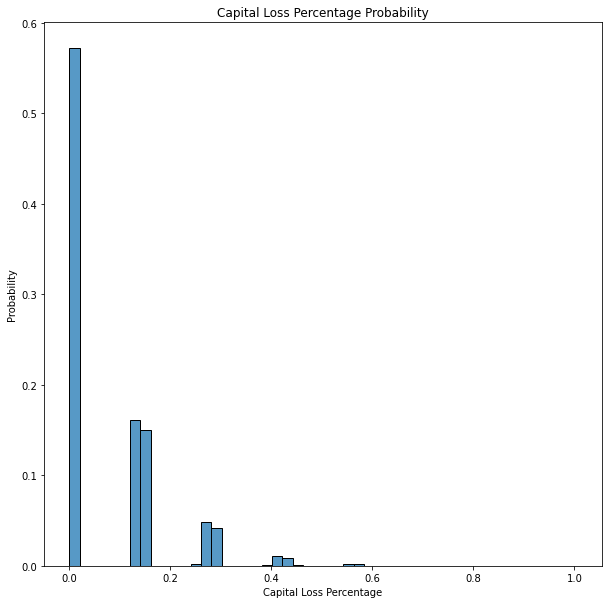

In [8]:
# Initialize the simulation engine
simulation_engine_normal = SimulationEngine(pool_array, pool_correlation_matrix)
simulation_engine_normal.simulate_paths(
    pool_array[-1].maturity_date, 50000)  
analysisEngine = AnalysisEngine(
    simulation_engine_normal)  # Initialize analysis engine
initial_investment = [1000/len(pool_array) for _ in range(len(pool_array))]
analysisEngine.visualize_capital_losses(initial_investment)

### Regime 3 - Pools are assigned 20% real world financing rates.

Initial investment total is  1000.0
10 percentile capital loss is 0.0
25 percentile capital loss is 0.0
50 percentile capital loss is 148.39383561643842
75 percentile capital loss is 291.3698630136989
99 percentile capital loss is 632.2315102140274
Mean capital loss is  164.1793051529849


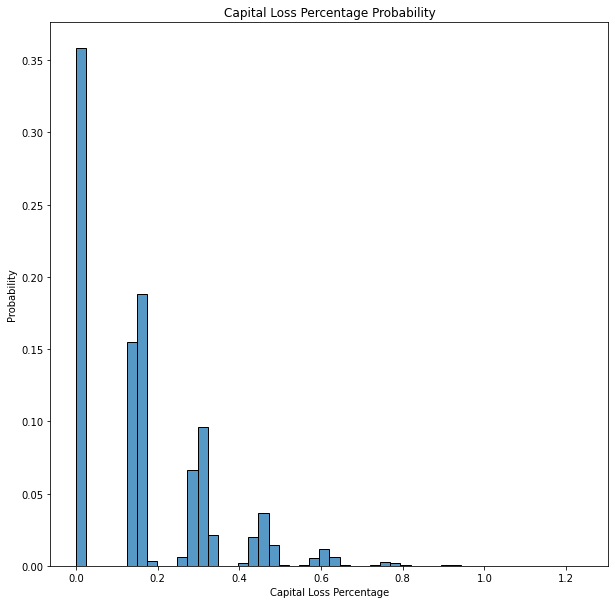

In [10]:
# Initialize the simulation engine
simulation_engine_high = SimulationEngine(high_risk_pool_array, pool_correlation_matrix)
simulation_engine_high.simulate_paths(
    pool_array[-1].maturity_date, 50000)  # Run simulations till
analysisEngine = AnalysisEngine(
    simulation_engine_high)  # Initialize analysis engine
initial_investment = [1000/len(pool_array) for _ in range(len(pool_array))]
analysisEngine.visualize_capital_losses(initial_investment)

### Regime 4 - Pools are assigned 20% real world financing rates but with no correlation

Initial investment total is  1000.0
10 percentile capital loss is 0.0
25 percentile capital loss is 0.0
50 percentile capital loss is 0.0
75 percentile capital loss is 253.67004169148345
99 percentile capital loss is 718.3597832042893
Mean capital loss is  137.62097093984525


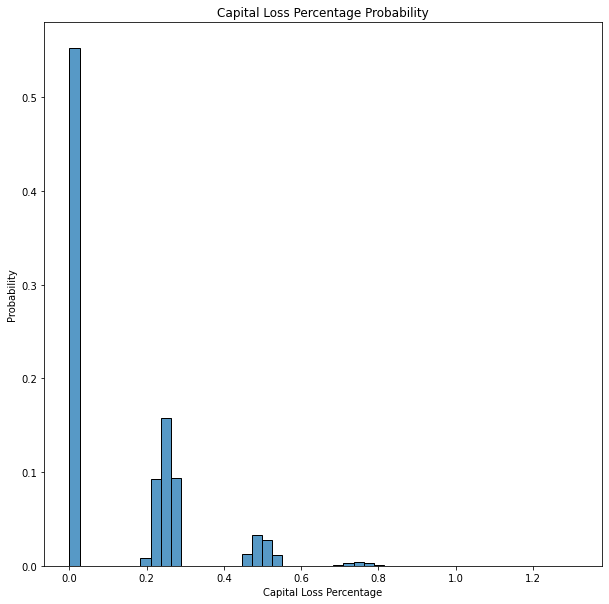

In [15]:
## Initialize the simulation engine
#simulation_engine = SimulationEngine(high_risk_pool_array, np.identity(len(high_risk_pool_array)))
#simulation_engine.simulate_paths(
#    pool_array[-1].maturity_date, 50000)  # Run simulations till
analysisEngine = AnalysisEngine(
    simulation_engine)  # Initialize analysis engine
initial_investment = [1000/5 for _ in range(len(pool_array))]
initial_investment[-1] = 0
initial_investment[-2] = 0
initial_investment[-3] = 0

analysisEngine.visualize_capital_losses(initial_investment)